<a href="https://colab.research.google.com/github/plance17/Aprendizaje-de-Maquina/blob/master/Redes_Neuronales_Gu%C3%ADa_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [174]:
pip install torchvision

In [175]:
pip install torchviz

In [205]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import numpy as np
import sklearn as skl
from torchviz import make_dot
import pandas as pd
import torch.optim as optim

In [202]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


In [177]:
#Cargo la base de datos de FashionMNIST

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)


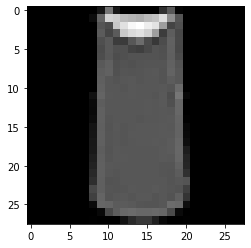

In [194]:
img=training_data[2][0]

#img  

plt.imshow(img.squeeze(), cmap="gray")
#plt.show()

In [195]:
# Creamos una subclase de Dataset que nos sirva para muestrear imagenes en el entrenamiento del autoencoder
class CustomImageDataset(Dataset):
    def __init__(self,dataset):
        self.dataset=dataset
    # Redefinimos el método .__len__()
    def __len__(self):
        return len(self.dataset)
    # Redefinimos el método .__getitem__()
    def __getitem__(self,i):
        image,label=self.dataset[i]
        label=torch.flatten(image) # Reescribimos el label original con una version achatada de la imagen.
        return image,label

training_data = CustomImageDataset(training_data)
test_data = CustomImageDataset(test_data)

In [197]:

#Tamaño de los batches
batch_size = 1000

#Núm de capas ocultas
n = 64

#Núm de épocas
epochs = 100

#dropout
p=0.1


# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)


In [208]:
class Autoencoder(nn.Module):
    def __init__(self,n=64,p=0.1):
        super(Autoencoder,self).__init__()
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p)
        self.linear1 = nn.Linear(28*28,n)
        self.linear2 = nn.Linear(n,n)
        self.linear3 = nn.Linear(n,28*28)
    def forward(self, x):
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.linear3(x)
        return x

In [230]:
model = Autoencoder().to(device)
print(model)

# Optimizamos los parámetros del modelo.
# Para ello, necesitamos definir una funcion error.
loss_fn = nn.MSELoss()

#Uso como optimizador el Método por el gradiente estocástico(SGD)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

Autoencoder(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (linear1): Linear(in_features=784, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=784, bias=True)
)


In [ ]:
data=[]
columns  = ["n","epoch","batch_size","step","loss_train",
            "loss_test"]

for t in range(epochs):
      print(f"Epoch {t+1}\n-------------------------------")
        

#Entrenamiento        
      size = len(train_dataloader.dataset)
      model.train()
      for batch, (X, y) in enumerate(train_dataloader): #Ingreso la matriz (x,y). La función enumerate agrega una columna inicial (i,x,y) que numera los valores i=0,1,2,......
        X, y = X.to(device), y.to(device)
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            loss_t, current = loss.item(), batch * len(X)
            print(f"loss: {loss_t:>7f}  [{current:>5d}/{size:>5d}]")

#Test Grupo de entrenamiento
      num_samples = len(train_dataloader.dataset)
      num_batches = len(train_dataloader)
      model.eval()
      avrg_loss_train = 0
      with torch.no_grad():
        for X, y in train_dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            avrg_loss_train += loss_fn(pred, y).item()
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            #Calculamos el nro de predicciones correctas, y lo acumulamos en el total
            #frac_correct += (pred.argmax(1)==y).type(torch.float).sum().item()
      #calculamos la perdida total y la fraccion de clasificaciones correctas, y las imprimimos
      avrg_loss_train /= num_batches
      print(f"Avg loss(Train): {avrg_loss_train:>8f} \n")

#Test Grupo de validación
      num_samples = len(test_dataloader.dataset)
      num_batches = len(test_dataloader)
      model.eval()
      avrg_loss_test = 0
      with torch.no_grad():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            avrg_loss_test += loss_fn(pred, y).item()
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            #Calculamos el nro de predicciones correctas, y lo acumulamos en el total
            #frac_correct += (pred.argmax(1)==y).type(torch.float).sum().item()
      #calculamos la perdida total y la fraccion de clasificaciones correctas, y las imprimimos
      avrg_loss_test /= num_batches
      print(f"Avg loss_test: {avrg_loss_test:>8f} \n")


      values = [n,t,batch_size,t,avrg_loss_train ,avrg_loss_test]
      data.append(dict(zip(columns, values)))


model_fname = "model-Adam-"+str(n)+"-"+str(epochs)+"-"+str(1)+"-"+str(batch_size)+".pth"
torch.save(model.state_dict(),model_fname)
#Guardamos los datos en pandas
model_fname = "model-Adam-"+str(n)+"-"+str(epochs)+"-"+str(1)+"-"+str(batch_size)+".csv"
df = pd.DataFrame()
df = df.append(data, True)
df.to_csv(model_fname)

Epoch 1
-------------------------------
loss: 0.210276  [    0/60000]
loss: 0.207887  [10000/60000]
loss: 0.203940  [20000/60000]
loss: 0.202797  [30000/60000]
loss: 0.204436  [40000/60000]
loss: 0.207256  [50000/60000]
Avg loss(Train): 0.203274 

Avg loss_test: 0.203300 

Epoch 2
-------------------------------
loss: 0.202116  [    0/60000]
loss: 0.201312  [10000/60000]
loss: 0.197878  [20000/60000]
loss: 0.197067  [30000/60000]
loss: 0.198726  [40000/60000]
loss: 0.201322  [50000/60000]
Avg loss(Train): 0.197192 

Avg loss_test: 0.197210 

Epoch 3
-------------------------------
loss: 0.196255  [    0/60000]
loss: 0.195386  [10000/60000]
loss: 0.191926  [20000/60000]
loss: 0.190930  [30000/60000]
loss: 0.192285  [40000/60000]
loss: 0.194655  [50000/60000]
Avg loss(Train): 0.189923 

Avg loss_test: 0.189928 

Epoch 4
-------------------------------
loss: 0.189470  [    0/60000]
loss: 0.188379  [10000/60000]
loss: 0.184591  [20000/60000]
loss: 0.183343  [30000/60000]
loss: 0.184323  [4

In [211]:
df

,n,epoch,batch_size,step,loss_train,loss_test
0,64,100,1000,0,0.215298,0.215337
1,64,100,1000,1,0.215074,0.215113
2,64,100,1000,2,0.214861,0.214899
3,64,100,1000,3,0.214657,0.214694
4,64,100,1000,4,0.214462,0.214499
...,...,...,...,...,...,...
95,64,100,1000,95,0.206560,0.206582
96,64,100,1000,96,0.206490,0.206512
97,64,100,1000,97,0.206420,0.206442
98,64,100,1000,98,0.206350,0.206372


<function matplotlib.pyplot.show>

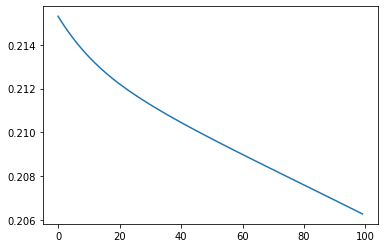

In [217]:
t=np.arange(0,100)

plt.plot(t,df.loss_train)
plt.show

TypeError: ignored

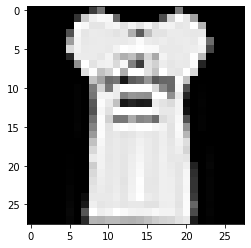

In [229]:
num=2

imag=X[num]
imag_ori=pred[num]

plt.imshow(imag.squeeze(),cmap='gray')
plt.imshow(imag_ori.squeeze(),cmap='gray')
plt.show()